In [6]:
pip install scikit-plot

## load libraries and the Drive





In [1]:
import glob, os.path
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import seaborn as sn
from sklearn.metrics import roc_curve,roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/Drive')  # import data from drive

Mounted at /content/Drive


In [3]:
import sys
sys.path.append('/content/drive')

## Load data

In [4]:
data_entrenamiento = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Train_final'
data_validacion = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Validation'
data_text = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Text'

## Graphics card provided by Google Colab

In [ ]:
!nvidia-smi

Fri Feb 12 13:17:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Model DenseNet201

In [ ]:
pre_trained_model = tf.keras.applications.DenseNet201(
                    include_top=False,
                    weights= 'imagenet',
                    input_shape = (224, 224, 3)
                    )

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:

for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name)

0 input_2
1 zero_padding2d
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block6_

In [ ]:
for layer in pre_trained_model.layers[:180]: #150
   layer.trainable = False
for layer in pre_trained_model.layers[180:]:
   layer.trainable = True

In [5]:
train_datagen = ImageDataGenerator( rescale = 1.0/255 )  # images normalization
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(data_entrenamiento,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    target_size=(224, 224),
                                                    )     

validation_generator =  validation_datagen.flow_from_directory(data_validacion,
                                                         batch_size=64,
                                                         class_mode  = 'categorical',
                                                         color_mode="rgb",
                                                         target_size = (224, 224))


test_generator =  test_datagen.flow_from_directory(data_text,
                                                         batch_size=64                                                   ,
                                                         color_mode="rgb",
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))



Found 32201 images belonging to 7 classes.
Found 7150 images belonging to 7 classes.
Found 3574 images belonging to 7 classes.


## Hidden Layer Design

In [ ]:
def model_new():
  inputs = tf.keras.Input(shape=(224, 224, 3))

  x = pre_trained_model(inputs)

  layers = tf.keras.layers.GlobalAveragePooling2D()(x)
  #layers = Flatten(name="flatten")(pre_trained_model)

  #Hidden Layers
  layers = Dense(512)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  layers = Dense(128)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(64)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(32)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  #classification layer
  predictions = Dense(7, activation="softmax", name="output_1")(layers)
  model = Model(inputs = inputs, outputs=predictions)

  return model

In [ ]:
modelFT = model_new()
modelFT.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

Optimazer

In [ ]:

modelFT.compile(
    optimizer="Adamax",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

In [ ]:

DESIRED_ACCURACY = 0.999
INIT_LR = 1e-3
def exp_decay(epoch):
  initial_lrate = 1e-3
  k = 0.095
  lrate = initial_lrate * np.exp(-k*epoch)
  return lrate



class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.lr = []

  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.lr.append(exp_decay(len(self.losses)))

class end_train(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,log={}):
            if log.get('val_accuracy')>DESIRED_ACCURACY:
                print("\nReached"+str(DESIRED_ACCURACY)+"% val_accuracy so cancelling training!")
                self.model.stop_training = True
end_t = end_train()
loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)       
callbacks_list = [loss_history,lrate,end_t]

callbacks=callbacks_list

## Train Model

In [ ]:
steps_per_epoch = train_generator.n // 64
validation_steps = validation_generator.n // 64
history = modelFT.fit (train_generator,             
                         validation_data = validation_generator,             
                         steps_per_epoch = steps_per_epoch,           
                         epochs = 33,             
                         validation_steps = validation_steps,             
                         verbose = 2,
                         callbacks=callbacks
                        ) 

Epoch 1/33
503/503 - 9303s - loss: 0.5929 - accuracy: 0.8074 - val_loss: 0.4497 - val_accuracy: 0.8497
Epoch 2/33
503/503 - 409s - loss: 0.2381 - accuracy: 0.9226 - val_loss: 0.2047 - val_accuracy: 0.9306
Epoch 3/33
503/503 - 409s - loss: 0.1298 - accuracy: 0.9594 - val_loss: 0.2223 - val_accuracy: 0.9274
Epoch 4/33
503/503 - 409s - loss: 0.0818 - accuracy: 0.9745 - val_loss: 0.1440 - val_accuracy: 0.9534
Epoch 5/33
503/503 - 409s - loss: 0.0451 - accuracy: 0.9878 - val_loss: 0.1161 - val_accuracy: 0.9630
Epoch 6/33
503/503 - 409s - loss: 0.0335 - accuracy: 0.9912 - val_loss: 0.1307 - val_accuracy: 0.9626
Epoch 7/33
503/503 - 409s - loss: 0.0260 - accuracy: 0.9930 - val_loss: 0.1395 - val_accuracy: 0.9579
Epoch 8/33
503/503 - 409s - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.1125 - val_accuracy: 0.9669
Epoch 9/33
503/503 - 409s - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.1004 - val_accuracy: 0.9704
Epoch 10/33
503/503 - 408s - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.1008 -

## Save the Model

In [ ]:


modelFT.save('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

#model = load_model('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')

In [ ]:
modelFT.save('/content/Drive/My Drive/HAM10000/tmp2/model')

# Results

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

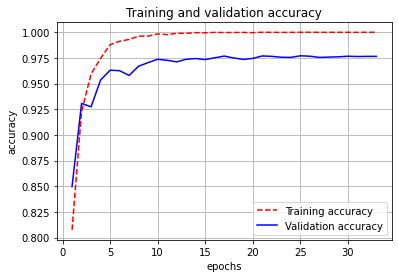

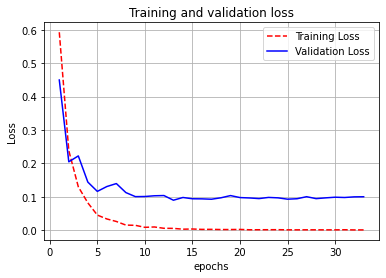

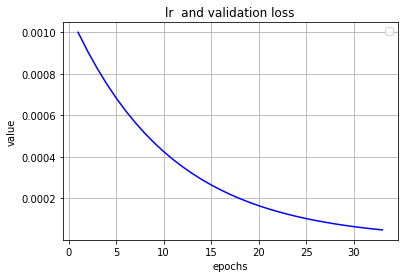

<Figure size 432x288 with 0 Axes>

In [ ]:

acc = history.history[ 'accuracy' ] # con drop
val_acc = history.history[ 'val_accuracy' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
lr = history.history['lr' ]
epochs = range(1,len(acc)+1,1)
plt.plot ( epochs, acc, 'r--', label='Training accuracy' )
plt.grid(True)
plt.plot ( epochs, val_acc, 'b', label='Validation accuracy')
plt.grid(True)
plt.title ('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot ( epochs, loss, 'r--' , label='Training Loss' )
plt.grid(True)
plt.plot ( epochs, val_loss , 'b', label='Validation Loss'  )
plt.grid(True)
plt.title ('Training and validation loss' )
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()
#plt.plot ( epochs, loss, 'r--' )
plt.plot ( epochs, lr, 'b' )
plt.grid(True)
plt.title ('lr  and validation loss' )
plt.ylabel('value')
plt.xlabel('epochs')
plt.legend()
plt.figure()

In [ ]:
epochs

range(1, 34)

In [8]:
from sklearn.metrics import f1_score

In [9]:
predicciones = []

In [10]:
for i in range(3574): #3574

  x = load_img(test_generator.filepaths[i], target_size=(224, 224))
  x = img_to_array(x)/255.
  x = np.expand_dims(x, axis=0)
  array = modelFT.predict(x)
  if i ==0:
      pred = array
  else:
      pred = np.append(pred, array, 0)
  val_preds = np.argmax(array , axis=-1)
  predicciones.append(val_preds)

In [35]:
pred.shape

(3574, 7)

In [36]:
labels.shape

(7,)

In [39]:
labels  = test_generator.classes

In [12]:
from sklearn.metrics import classification_report

In [13]:
cm = confusion_matrix(labels, predicciones)

In [14]:
cm

array([[491,   0,   1,   0,   1,   0,   0],
       [  0, 542,   0,   0,   1,   0,   0],
       [  3,   0, 518,   0,  10,   7,   0],
       [  0,   0,   0, 441,   0,   0,   0],
       [  0,   1,  14,   0, 472,  14,   0],
       [  1,   1,  11,   1,   9, 534,   1],
       [  0,   0,   0,   0,   0,   0, 500]])

In [15]:
f1_score(labels, predicciones, average='micro')

0.978735310576385

In [16]:
f1_score(labels, predicciones, average='macro')

0.9793983987347972

In [17]:
f1_score(labels, predicciones, average='weighted')

0.9787001136030022

In [18]:
target_names = ["class 0", "class 1", "class 2", "class 3", "class 4", "class 5", "class 6"]

In [19]:
labels.shape

(3574,)

In [20]:
len(predicciones)

3574

In [21]:
visualizer = classification_report(labels, predicciones, target_names=target_names)


In [22]:
print(visualizer)

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99       493
     class 1       1.00      1.00      1.00       543
     class 2       0.95      0.96      0.96       538
     class 3       1.00      1.00      1.00       441
     class 4       0.96      0.94      0.95       501
     class 5       0.96      0.96      0.96       558
     class 6       1.00      1.00      1.00       500

    accuracy                           0.98      3574
   macro avg       0.98      0.98      0.98      3574
weighted avg       0.98      0.98      0.98      3574



In [23]:
pre = np.array(predicciones)
labe = np.array(labels)

In [24]:
#np.save('/content/Drive/MyDrive/imágenes convertidas a formato eps/prediction3',pre)
#np.save('/content/Drive/MyDrive/imágenes convertidas a formato eps/labels3',labe)

In [40]:
true = labels
pred2 = np.copy(predicciones)
labels2 = np.arange(7)
target_names = list(range(7))

In [41]:
clf_report = classification_report(true,
                                   pred2,
                                   labels=labels2,
                                   target_names=target_names,
                                   output_dict=True)

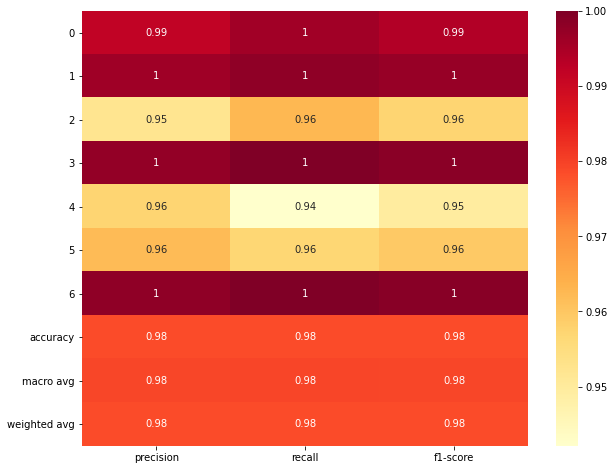

In [26]:
plt.figure(figsize = (10,8))  
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='YlOrRd',linecolor='red')
plt.savefig('/content/Drive/MyDrive/imágenes convertidas a formato eps/metricas3.eps', format='eps')

In [42]:
y_label = label_binarize(labels, classes=[0,1,2,3,4,5,6])

In [43]:
y_label.shape

(3574, 7)

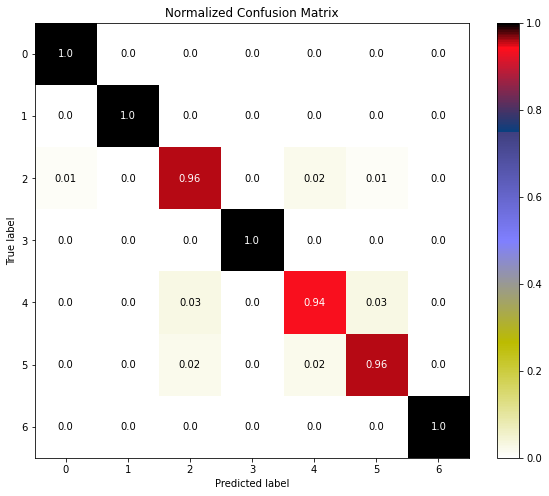

In [77]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(labels, pred2, normalize=True,cmap='gist_stern_r',figsize=(10,8))

plt.show()

In [45]:
# 7 Categoires
n_classes = 7

In [46]:
y_test = pred

lw = 2

In [47]:
etiqt = np.array(labels)

In [79]:
pred2 = label_binarize(predicciones, classes=[0,1,2,3,4,5,6])

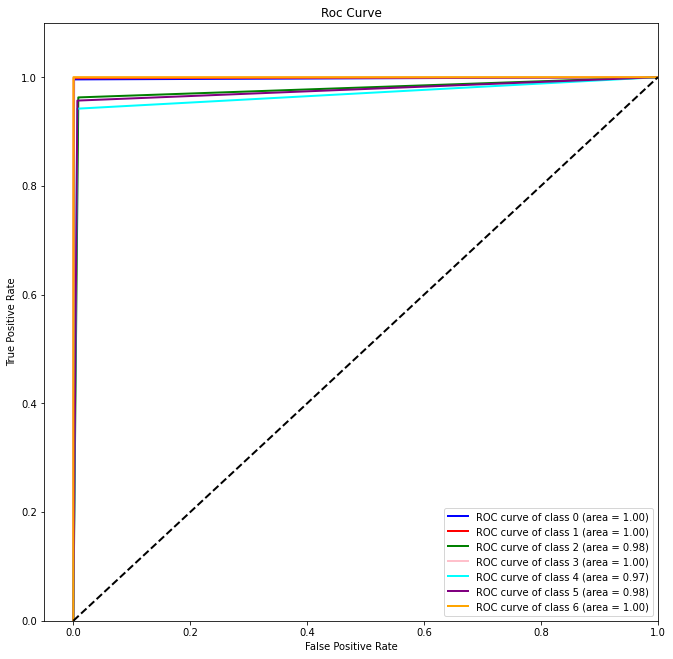

In [80]:
fpr = dict()
tpr = dict()
roc_auc2 = dict()
plt.figure(figsize = (11,11))  
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve( y_label[:, i], pred2[:, i])
    roc_auc2[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green','pink','cyan','purple','orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('/content/Drive/MyDrive/imágenes convertidas a formato eps/curva_roc3.eps', format='eps')

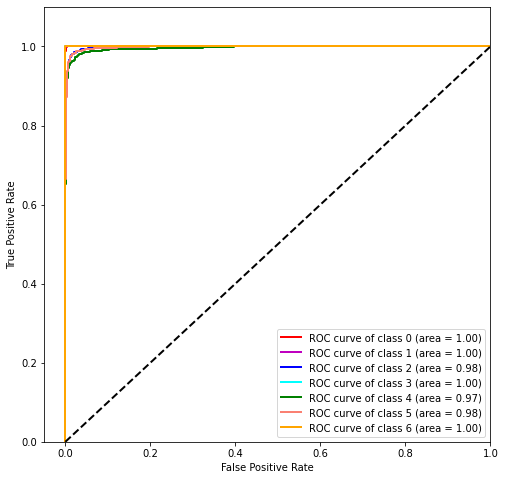

In [81]:
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize = (8,8))  
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve( y_label[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red','m', 'blue', 'cyan', 'green', 'salmon', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")

#plt.savefig('/content/Drive/MyDrive/imágenes convertidas a formato eps/modelo final_densenet201.eps', format='eps')

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [50]:
label = ['0','1','2','3','4','5','6']

In [87]:
def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

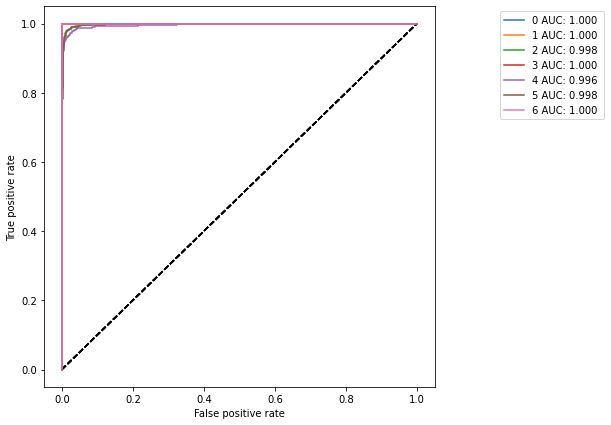

In [89]:
get_curve(y_label, pred, label,curve='roc')

In [56]:
y_score = pred
y_test = y_label

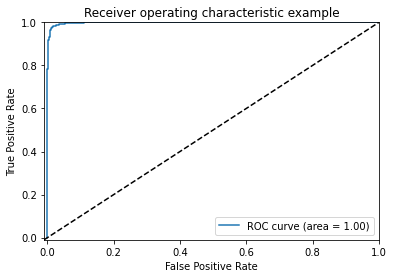

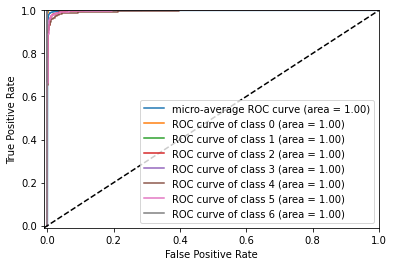

In [57]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([-0.01, 1.0], [-0.01, 1.0], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

#plt.plot([0, 1], [0, 1], 'k--')
plt.plot([-0.01, 1.0], [-0.01, 1.0], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig('roc.svg')
plt.show()

In [59]:
from scipy.stats import percentileofscore


def score_ci(
    y_true,
    y_pred,
    score_fun,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given score function based on labels and predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred: 1D list or array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Score evaluated on labels and predictions, lower confidence interval, upper confidence interval, array of
    bootstrapped scores.
    """

    assert len(y_true) == len(y_pred)

    score = score_fun(y_true, y_pred)
    _, ci_lower, ci_upper, scores = score_stat_ci(
        y_true=y_true,
        y_preds=y_pred,
        score_fun=score_fun,
        n_bootstraps=n_bootstraps,
        confidence_level=confidence_level,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )

    return score, ci_lower, ci_upper, scores


def score_stat_ci(
    y_true,
    y_preds,
    score_fun,
    stat_fun=np.mean,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given statistic of a score function based on labels and predictions using
    bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds: A list of lists or 2D array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which confidence interval is computed. (e.g. np.mean)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Mean score statistic evaluated on labels and predictions, lower confidence interval, upper confidence
    interval, array of bootstrapped scores.
    """

    y_true = np.array(y_true)
    y_preds = np.atleast_2d(y_preds)
    assert all(len(y_true) == len(y) for y in y_preds)

    np.random.seed(seed)
    scores = []
    for i in range(n_bootstraps):
        readers = np.random.randint(0, len(y_preds), len(y_preds))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers:
            reader_scores.append(score_fun(y_true[indices], y_preds[r][indices]))
        scores.append(stat_fun(reader_scores))

    mean_score = np.mean(scores)
    sorted_scores = np.array(sorted(scores))
    alpha = (1.0 - confidence_level) / 2.0
    ci_lower = sorted_scores[int(round(alpha * len(sorted_scores)))]
    ci_upper = sorted_scores[int(round((1.0 - alpha) * len(sorted_scores)))]
    return mean_score, ci_lower, ci_upper, scores


def pvalue(
    y_true,
    y_pred1,
    y_pred2,
    score_fun,
    n_bootstraps=2000,
    two_tailed=True,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute p-value for hypothesis that score function for model I predictions is higher than for model II predictions
    using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred1: 1D list or array of predictions for model I corresponding to elements in y_true.
    :param y_pred2: 1D list or array of predictions for model II corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param two_tailed: Whether to use two-tailed test. (default: True)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Computed p-value, array of bootstrapped differences of scores.
    """

    assert len(y_true) == len(y_pred1)
    assert len(y_true) == len(y_pred2)

    return pvalue_stat(
        y_true=y_true,
        y_preds1=y_pred1,
        y_preds2=y_pred2,
        score_fun=score_fun,
        n_bootstraps=n_bootstraps,
        two_tailed=two_tailed,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )


def pvalue_stat(
    y_true,
    y_preds1,
    y_preds2,
    score_fun,
    stat_fun=np.mean,
    n_bootstraps=2000,
    two_tailed=True,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute p-value for hypothesis that given statistic of score function for model I predictions is higher than for
    model II predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds1: A list of lists or 2D array of predictions for model I corresponding to elements in y_true.
    :param y_preds2: A list of lists or 2D array of predictions for model II corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which p-value is computed. (e.g. np.mean)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param two_tailed: Whether to use two-tailed test. (default: True)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Computed p-value, array of bootstrapped differences of scores.
    """

    y_true = np.array(y_true)
    y_preds1 = np.atleast_2d(y_preds1)
    y_preds2 = np.atleast_2d(y_preds2)
    assert all(len(y_true) == len(y) for y in y_preds1)
    assert all(len(y_true) == len(y) for y in y_preds2)

    np.random.seed(seed)
    z = []
    for i in range(n_bootstraps):
        readers1 = np.random.randint(0, len(y_preds1), len(y_preds1))
        readers2 = np.random.randint(0, len(y_preds2), len(y_preds2))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers1:
            reader_scores.append(score_fun(y_true[indices], y_preds1[r][indices]))
        score1 = stat_fun(reader_scores)
        reader_scores = []
        for r in readers2:
            reader_scores.append(score_fun(y_true[indices], y_preds2[r][indices]))
        score2 = stat_fun(reader_scores)
        z.append(score1 - score2)

    p = percentileofscore(z, 0.0, kind="weak") / 100.0
    if two_tailed:
        p *= 2.0
    return p, z

In [60]:
y_true = y_label
y_pred = pred

In [61]:
from sklearn.metrics import roc_auc_score
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, i], y_pred[:, i], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


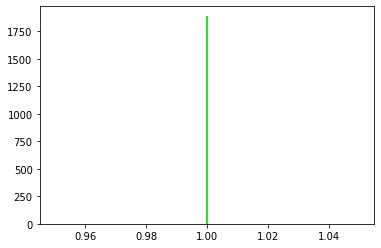

In [62]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [63]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 0], y_pred[:, 0], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


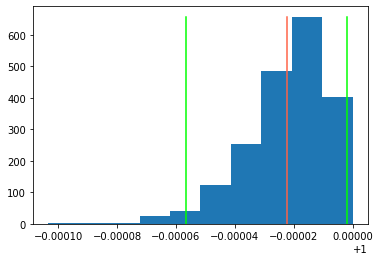

In [64]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [65]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 1], y_pred[:, 1], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


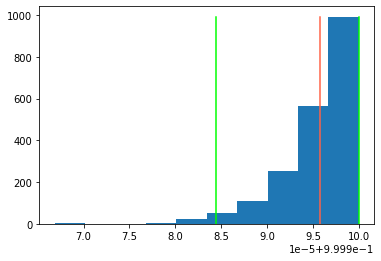

In [66]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [67]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 2], y_pred[:, 2], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


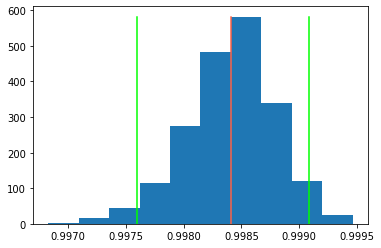

In [68]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [69]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 3], y_pred[:, 3], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


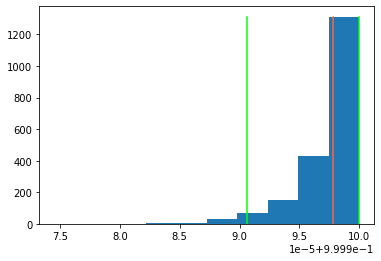

In [70]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [71]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 4], y_pred[:, 4], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 0.99-1.00


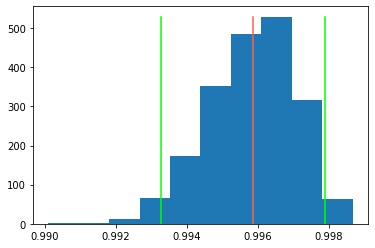

In [72]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [73]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 5], y_pred[:, 5], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


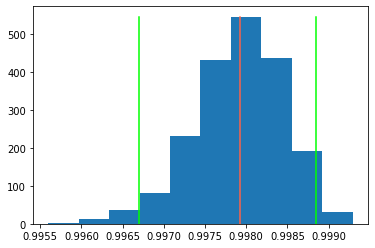

In [74]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

In [75]:
# AUC with 95% confidence interval for a single model

score, ci_lower, ci_upper, scores = score_ci(y_true[:, 6], y_pred[:, 6], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

AUC=1.00, 95% CI: 1.00-1.00


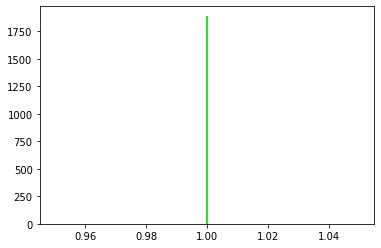

In [76]:
bins = plt.hist(scores)
plt.plot([score, score], [0, np.max(bins[0])], color="tomato")
plt.plot([ci_lower, ci_lower], [0, np.max(bins[0])], color="lime")
plt.plot([ci_upper, ci_upper], [0, np.max(bins[0])], color="lime")
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))

Load model

In [7]:
modelFT = load_model('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')

In [ ]:
modelFT = load_model('/content/Drive/MyDrive/modelos Ham10000/modelo final_Densenet201.h5')

In [ ]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)